In [14]:
import pandas
from pandas.io.json import json_normalize
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import time
from praveganb.pravega_stream import *
import grpc
import simplejson as json
import collections
from scipy.stats import norm
import numpy as np
import collections
import math
%matplotlib inline

In [15]:
gateway = '10.243.37.127:80'
scope = 'idracdemo'
stream = 'idracdata'

In [16]:
pravega_channel = grpc.insecure_channel(gateway)
pravega_client = pravega.grpc.PravegaGatewayStub(pravega_channel)

In [17]:
unindexed_stream = UnindexedStream(pravega_client, scope, stream)
stream_info = unindexed_stream.get_stream_info()
stream_info

head_stream_cut {
  text: "H4sIAAAAAAAAADOwykwpSkxOSc3N14ewEksSrUx0THWMrQx0gBBCAgCqKE54JwAAAA=="
  cut {
    key: 3
    value: 0
  }
  cut {
    key: 4
    value: 0
  }
  cut {
    key: 5
    value: 0
  }
}
tail_stream_cut {
  text: "H4sIAAAAAAAAADOwykwpSkxOSc3N14ewEksSrUx0THWMrQx0gNDK2MzA1NTA3NTSXMfYxNLS1NLA0tAYyASKGFuYWhgDAOgnLIdCAAAA"
  cut {
    key: 3
    value: 3475938583
  }
  cut {
    key: 4
    value: 3605507597
  }
  cut {
    key: 5
    value: 3499590913
  }
}

In [18]:
stream_size_MB = (list(stream_info.tail_stream_cut.cut.values())[0] - list(stream_info.head_stream_cut.cut.values())[0]) * 1e-6
stream_size_MB

3605.507597

In [19]:
anchorsteam = [
    '10.243.19.152',
    '10.243.19.153',
    '10.243.19.154',
    '10.243.19.155',
    '10.243.19.156',
    '10.243.19.157',
    '10.243.19.158'
              ]
eaglemonk = [ 
    '10.243.19.70',
    '10.243.19.72', 
    '10.243.19.74' , 
    '10.243.19.76', 
    '10.243.19.78', 
    '10.243.19.80', 
    '10.243.19.82',
    '10.243.19.84'
            ]

In [20]:
text = "H4sIAAAAAAAAADOwykwpSkxOSc3N14ewEksSrUx0THWMrQx0gBBCAgCqKE54JwAAAA=="
from_stream_cut = pravega.pb.StreamCut(text=text)
read_events = unindexed_stream.read_events_from_stream(from_stream_cut, None)
count = 0
reports = []
for i, event in enumerate(read_events):
    metric_report = dict(event)
    if metric_report.get('MetricValues') and metric_report.get('Id') == 'CUPS' and metric_report.get('RemoteAddr') in anchorsteam:
        _report = dict()
        sum = 0
        cnt = 0
        for metric in metric_report.get('MetricValues'):
            if metric.get('MetricId') == 'CPUUsage':
                try:
                    sum += float(metric['MetricValue'])
                    cnt += 1
                except:
                    pass
        _report['Timestamp'] = metric_report['Timestamp']
        _report['RemoteAddr'] = metric_report['RemoteAddr']
        _report['Id'] = metric_report['Id']
        _report['MetricId'] = 'CPUUsage'
        _report['avg'] = sum/cnt
        reports.append(_report)
        count += 1
    if count >= 1000:
        break
display(pandas.DataFrame.from_dict(reports, orient='columns'))

,Timestamp,RemoteAddr,Id,MetricId,avg
0,2020-03-31T21:21:29.099Z,10.243.19.157,CUPS,CPUUsage,12.666667
1,2020-03-31T21:21:33.932Z,10.243.19.153,CUPS,CPUUsage,50.666667
2,2020-03-31T21:21:34.594Z,10.243.19.158,CUPS,CPUUsage,18.250000
3,2020-03-31T21:21:35.097Z,10.243.19.156,CUPS,CPUUsage,37.666667
4,2020-03-31T21:21:36.165Z,10.243.19.152,CUPS,CPUUsage,49.833333
...,...,...,...,...,...
995,2020-03-31T21:28:59.070Z,10.243.19.156,CUPS,CPUUsage,36.000000
996,2020-03-31T21:29:00.159Z,10.243.19.152,CUPS,CPUUsage,50.666667
997,2020-03-31T21:29:00.660Z,10.243.19.158,CUPS,CPUUsage,16.500000
998,2020-03-31T21:28:18.560Z,10.243.19.157,CUPS,CPUUsage,18.916667


In [21]:
s1 = 0
s2 = 0
count = 0
mean = 0
for report in reports:
    s1 += report['avg']
    s2 += pow(report['avg'], 2)
    count += 1
# calculate mean
mean = s1/count
# (sqrt(count*.s2 - pow(s1, 2)))/count
std = (math.sqrt(count*s2 - pow(s1, 2)))/count
std, mean, count

(15.012559412177906, 32.306249999999864, 1000)

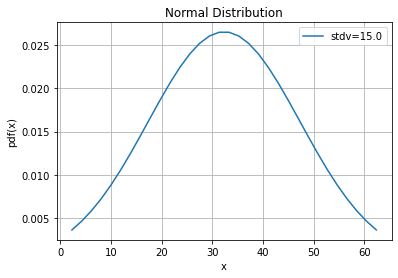

In [22]:
fig, ax = plt.subplots()
x = np.linspace(mean-2*std,mean+2*std, int(mean))
ax.plot(x, norm.pdf(x, scale=std, loc=mean), label='stdv=%.1f' % std)
ax.set_xlabel('x')
ax.set_ylabel('pdf(x)')
ax.set_title('Normal Distribution')
ax.legend(loc='best', frameon=True)
#ax.set_ylim(0,0.45)
ax.grid(True)

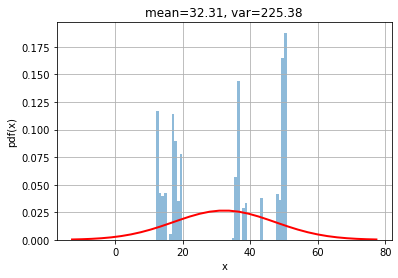

In [23]:
fig, ax = plt.subplots()
xs = [i['avg'] for i in reports ]
#print(xs)
x = np.linspace(mean-3*std,mean+3*std, int(mean))
p = norm.pdf(x, scale=std, loc=mean)
v = np.var(xs)
m = np.mean(xs)
# ax = fig.add_subplot(111)
ax.hist(xs, bins=50, alpha=0.5, density=True)
ax.plot(x, p, 'r-', lw=2)
ax.set_xlabel('x')
ax.set_ylabel('pdf(x)')
ax.set_title(f'mean={m:.2f}, var={v:.2f}')
ax.grid(True)

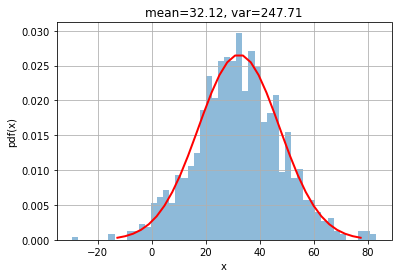

In [24]:
fig, ax = plt.subplots()
xs = norm.rvs(scale=std,loc=mean, size=1000) # [i['avg'] for i in reports ]
#print(xs)
x = np.linspace(mean-3*std,mean+3*std, int(mean))
p = norm.pdf(x, scale=std, loc=mean)
v = np.var(xs)
m = np.mean(xs)
# ax = fig.add_subplot(111)
ax.hist(xs, bins=50, alpha=0.5, density=True)
ax.plot(x, p, 'r-', lw=2)
ax.set_xlabel('x')
ax.set_ylabel('pdf(x)')
ax.set_title(f'mean={m:.2f}, var={v:.2f}')
ax.grid(True)